In [9]:
!pip install -q pygame numpy torch matplotlib

### Importieren

In [1]:
import pygame  # Spielentwicklung
import random  
import numpy as np  
import torch  
import torch.nn as nn  
import torch.optim as optim 
import torch.nn.functional as F
import os  
import matplotlib.pyplot as plt

from enum import Enum  # Aufzählungen
from collections import namedtuple  # Benannte Tupel
from collections import deque  # Queue
from game import SnakeGameAI, Direction, Point  # Spiel-Logik
from model import Linear_QNet, QTrainer  # Modell (Q-Learning)
from visualisierung import plot 

pygame 2.6.1 (SDL 2.28.4, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Hauptkomponenten des Spiels


In [2]:
pygame.init()
font = pygame.font.SysFont('Arial', 30)

# Farben
WHITE = (255, 255, 255)
BEIGE = (245, 245, 220)  #Hintergrund
LIGHT_GREEN = (144, 238, 144)  #für den Körper
DARK_GREEN = (0, 100, 0)  #für den Kopf
RED = (200, 0, 0)  #für das Futter
BLACK = (0, 0, 0)  #für den Score
GOLD = (255, 215, 0)  # Bonus
DARK_GRAY = (169, 169, 169)  #für den Rahmen und den Hintergrund

BLOCK_SIZE = 20
SPEED = 15
MAX_FRAME_ITERATION = 100 * BLOCK_SIZE  # Maximale Schritte pro Schlange


class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

class SnakeGameAI:
    def __init__(self, w=640, h=480):
        self.w = w # Setzt die Breite des Fensters
        self.h = h # Setzt die Höhe des Fensters
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Snake Game AI')
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self):
        """Setzt den Zustand des Spiels zurück."""
        self.direction = Direction.RIGHT
        self.head = Point(self.w / 2, self.h / 2) # Setzt die Position des Schlangenkopfes
        self.snake = [self.head,
                      Point(self.head.x - BLOCK_SIZE, self.head.y),
                      Point(self.head.x - (2 * BLOCK_SIZE), self.head.y)]
        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0
        self.level = 1
        self.speed_increase = 2  # Geschwindigkeitserhöhung pro Level

    def _place_food(self):
        """Platziert das Futter an einer zufälligen Position."""
        x = random.randint(0, (self.w - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE ## Berechnet die x-Position des Futters.
        y = random.randint(0, (self.h - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake: # Überprüft, ob das Futter zufällig auf einem Schlangensegment liegt und platziert es dann neu.
            self._place_food() 

    def play_step(self, action):
        """Ein Schritt im Spiel."""
        self.frame_iteration += 1
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

        reward = 0
        game_over = False

        self._move(action)
        self.snake.insert(0, self.head)

        if self.is_collision() or self.frame_iteration > MAX_FRAME_ITERATION:
            game_over = True
            reward = -10
            return reward, game_over, self.score

        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()

            # Steigerung der Geschwindigkeit jedes Mal, wenn die Schlange wächst
            if self.score % 10 == 0:
                self.level += 1
                global SPEED
                SPEED += self.speed_increase
                print(f"Level up! Level: {self.level}, Speed: {SPEED}")

        else:
            self.snake.pop()

        self._update_ui()
        self.clock.tick(SPEED)
        return reward, game_over, self.score

    def is_collision(self, pt=None):
        """Überprüft Kollisionen mit den Wänden oder der Schlange selbst."""
        if pt is None:
            pt = self.head
        if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
            return True
        if pt in self.snake[1:]:
            return True
        return False

    def _update_ui(self):
        """Aktualisiert das UI, einschließlich Hintergrund, Schlange, Futter und Punktzahl."""
        self.display.fill(BEIGE)  # Beige Hintergrund
        self._draw_border()
        self._draw_snake()
        self._draw_food()
        self._draw_score()

        pygame.display.flip()

    def _draw_border(self):
        """Zeichnet einen Rahmen um das Spielfeld."""
        pygame.draw.rect(self.display, DARK_GRAY, pygame.Rect(0, 0, self.w, self.h), 5)

    def _draw_snake(self):
        """Zeichnet die Schlange auf dem Bildschirm."""
        for i, pt in enumerate(self.snake):
            if i == 0:  # Kopf der Schlange
                pygame.draw.circle(self.display, DARK_GREEN, (pt.x + BLOCK_SIZE // 2, pt.y + BLOCK_SIZE // 2), BLOCK_SIZE // 2)
            else:  # Körper der Schlange
                pygame.draw.circle(self.display, LIGHT_GREEN, (pt.x + BLOCK_SIZE // 2, pt.y + BLOCK_SIZE // 2), BLOCK_SIZE // 2)

    def _draw_food(self):
        """Zeichnet das Futter."""
        pygame.draw.circle(self.display, RED, (self.food.x + BLOCK_SIZE // 2, self.food.y + BLOCK_SIZE // 2), BLOCK_SIZE // 2)

    def _draw_score(self):
        """Zeigt den aktuellen Punktestand an."""
        score_text = font.render(f"Score: {self.score}  Level: {self.level}", True, BLACK)
        self.display.blit(score_text, [10, 10])

    def _move(self, action):
        """Bewegt die Schlange basierend auf der Eingabeaktion."""
        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)

        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx]  # Keine Änderung
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx]  # Rechtsdrehung
        else:
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx]  # Linksdrehung

        self.direction = new_dir

        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

### Grundlegenden Bausteine für ein Deep- Q-Learning-Modell mit einem neuronalen Netzwerk
#### ( Regeln, Umgebung, neuronales Netzwerk, Trainingslogik )

In [3]:
# Konstanten
MAX_MEMORY = 100_000  # Maximale Anzahl von gespeicherten Erfahrungen.(auf vergangene Erfahrungen zurückgreifen)
BATCH_SIZE = 1000  # Anzahl der Erfahrungen, die in einem Schritt zum Training verwendet werden.
LR = 0.001  # Lernrate: Bestimmt, wie stark das Modell bei jedem Schritt angepasst wird.


# Definition der Klasse für das Q-Learning-Modell
class Linear_QNet(nn.Module):  #Ein neuronales Netz der geschätzten Q-Werte.

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)  # Erste lineare Schicht
        self.linear2 = nn.Linear(hidden_size, output_size)  # Zweite lineare Schicht

    def forward(self, x):
        x = F.relu(self.linear1(x))  # Aktivierung der ersten Schicht mit ReLU (Nichtlineare Bz lernen:komplexe Beziehungen)
        x = self.linear2(x)          # Ausgabe durch die zweite Schicht
        return x                     

    def save(self, file_name='model.pth'):
        model_folder_path = './model'  # Ordner für das Speichern der Modelle
        if not os.path.exists(model_folder_path):  
            os.makedirs(model_folder_path)        

        file_name = os.path.join(model_folder_path, file_name) 
        torch.save(self.state_dict(), file_name)               # Speichern der Modellparameter

# Definition der Trainingslogik für Q-Learning (Bestandteil RL)
class QTrainer: 
    def __init__(self, model, lr, gamma):
        self.lr = lr  
        self.gamma = gamma                     
        self.model = model                     
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)  # Adam-Optimierer (verbessert klassischen Gradientenabstiegsalgorithmus)
        self.criterion = nn.MSELoss()          # Verlustfunktion: Mean Squared Error(Vorhersagewert optimieren)

    def train_step(self, state, action, reward, next_state, done):
        # Konvertieren der Eingaben in Tensoren (NN Erforderlich)
        state = torch.tensor(state, dtype=torch.float32)       # Zustand
        next_state = torch.tensor(next_state, dtype=torch.float32)  
        action = torch.tensor(action, dtype=torch.long)        # Aktion
        reward = torch.tensor(reward, dtype=torch.float32)     # Belohnung

        
        if len(state.shape) == 1:              # Falls die Eingabe eindimensional ist
            state = torch.unsqueeze(state, 0)  # Hinzufügen einer Batch-Dimension
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )                    # Umwandeln von done in ein Tupel

        # Vorhersage der aktuellen Q-Werte
        pred = self.model(state)               

        # Berechnung der Ziel-Q-Werte
        target = pred.clone()                  # Kopieren der vorhergesagten Q-Werte
        for idx in range(len(done)):           # Iteration über alle Einträge im Batch
            Q_new = reward[idx]                # Initialer Q-Wert ist die Belohnung
            if not done[idx]:                  # Wenn nicht abgeschlossen 
                with torch.no_grad():          # Keine Gradientenberechnung
                    Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))  # Aktualisieren

            target[idx][torch.argmax(action[idx]).item()] = Q_new  # Ziel-Q-Wert setzen

        # Berechnung des Verlusts und Backpropagation
        self.optimizer.zero_grad()             # Zurücksetzen der Gradienten
        loss = self.criterion(target, pred)    # Verlust berechnen
        loss.backward()                        # Backpropagation durchführen
        self.optimizer.step()                  

![Bildbeschreibung](https://lh4.googleusercontent.com/proxy/KQMB740gkpqWidYF22kaJbhvRU8t3PX4tDA1FIEwPyEOCqGtzoh4fjuQohi20huVbpeL0ldkhIozcpc5rlU7TZhBHCxTyAKOaFdp3OmndZ-5Uo3KRNoOag)


### Agenten-basiertes Deep Q-Learning Modell
#### (Beobachtet, trifft Entscheidungen, lernt und agiert in der Umgebung)

<Figure size 640x480 with 0 Axes>

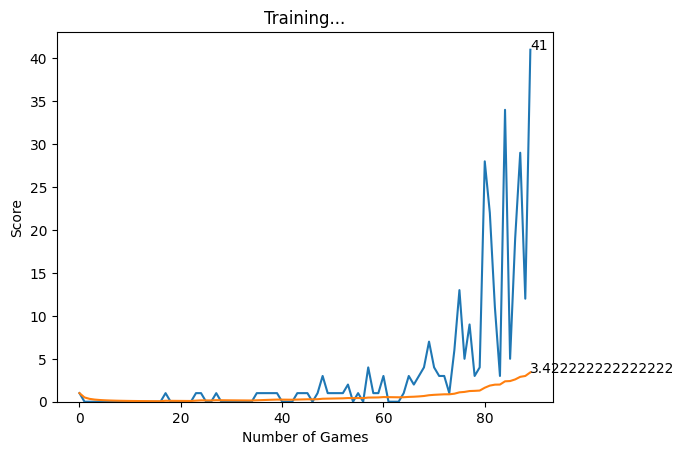

error: display Surface quit

In [4]:
class Agent: 

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0  # zufälligkeit
        self.gamma = 0.9  
        self.memory = deque(maxlen=MAX_MEMORY)  # Replay Memory für Erfahrungen. .(auf vergangene Erfahrungen zurückgreifen)
        self.model = Linear_QNet(11, 256, 3) #11 Eingabewerte, 256 Neuronen im versteckten Layer und 3 Ausgänge
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    # Berechnet Zustand des Spielers
    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)

        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN
        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),

            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,

            # Food location 
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
        ]
        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # Speichert die Erfahrung

    def train_long_memory(self): # Nutzt einen Mini-Batch von gespeicherten Erfahrungen
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) 
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done): # Trainiert das Modell direkt nach einer Aktion
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        self.epsilon = 80 - self.n_games  # Exploration (neue Aktionen erkunden) nimmt mit der Anzahl der Spiele ab

        if random.randint(0, 200) < self.epsilon:  # Wenn Exploration nötig ist
            move = random.randint(0, 2)  # Zufällige Aktion (Exploration)
        else:
            state0 = torch.tensor(state, dtype=torch.float)  # Konvertiert Zustand in Tensor
            prediction = self.model(state0)  # Lässt Modell eine Vorhersage machen
            move = torch.argmax(prediction).item()  # Wählt die Aktion mit dem höchsten Q-Wert
        final_move = [0, 0, 0]  # Initialisiert die Bewegungsaktion
        final_move[move] = 1  # Setzt die ausgewählte Aktion auf 1
        return final_move  # Gibt die kodierte Aktion zurück


def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        state_old = agent.get_state(game)  # Holen des aktuellen Zustands
        final_move = agent.get_action(state_old)  # Auswahl der Aktion durch den Agenten
        reward, done, score = game.play_step(final_move)  # Spielt die Aktion aus und erhält Belohnung
        state_new = agent.get_state(game)  # Neuer Zustand nach der Aktion
        agent.train_short_memory(state_old, final_move, reward, state_new, done)  # Schnelles Training für aktuellen Schritt
        agent.remember(state_old, final_move, reward, state_new, done)  # Speichert den Schritt in Replay Memory
        
        if done:
            game.reset()  # Startet das Spiel neu
            agent.n_games += 1  # Erhöht die Spielanzahl
            agent.train_long_memory()  # Trainiert das Modell mit gespeicherten Erinnerungen

            if score > record:
                record = score
                agent.model.save()

            print('Game:', agent.n_games, 'Score:', score, 'Record:', record)  # Ausgabe des aktuellen Spiels, Punktestand und Rekord
            plot_scores.append(score) 
            total_score += score  # Addiere den aktuellen Punktestand zum Gesamtscore
            mean_score = total_score / agent.n_games  
            plot_mean_scores.append(mean_score)  

            
            plot(plot_scores, plot_mean_scores)


if __name__ == '__main__':
    train()